# Motivação

Desde criança sempre fui fascinado por observar o céu e tentar entender os mistérios que ele esconde. Eu passava horas olhando para as estrelas, tentando imaginar o que poderia haver além do que podia ver. Quando cresci, minha paixão pelo universo só aumentou e eu decidi que queria fazer da astronomia uma parte importante da minha vida.

Dentre as várias coisas que faço em meu tempo livre, uma das mais prazerosas é apontar minha câmera SCB-2000N para uma região do céu e deixá-la gravando por um período prolongado de tempo. Eu faço isso com a esperança de conseguir capturar a passagem de algum bólido. O problema é que, com tantas horas de gravação, é inviável ter que assistir a tudo para verificar se houve a passagem de algum objeto.

Foi então que eu tive a ideia de juntar duas das minhas maiores paixões: o desenvolvimento de *software* e a astronomia. Eu resolvi criar uma *[playlist](https://youtube.com/playlist?list=PL_AicbRG9Iu-B9rPbiXn77cs1u9qKErei)* em meu canal no YouTube para compartilhar minhas observações e o progresso de um algoritmo que estou desenvolvendo para facilitar a detecção de passagens de objetos.

Desde que comecei a gravar os vídeos e a desenvolver o algoritmo, tive que me aperfeiçoar em várias coisas que eu nem imaginaria que seria necessário estudar para criar um simples algoritmo de detecção de passagens de objetos. Aqui neste repositório do GitHub, você pode encontrar o algoritmo que estou desenvolvendo e uma explicação de como utilizá-lo.

# Metodologia

A metodologia empregada consiste em processar as imagens extraídas de um vídeo previamente gravado. O objetivo é detectar a passagem de objetos através da realização de uma análise frame a frame do vídeo. A partir desta análise, é possível criar um conjunto de dados com o desvio padrão de cada um dos frames. Verifica-se então quais intervalos de dados apresentam anomalias, pois é através delas que se pode identificar a detecção de um objeto. Este método foi aplicado com sucesso e permitiu a detecção de passagens de objetos em diversos vídeos.

# Desenvolvimento

### Instalação dos módulos Python necessários

In [1]:
!pip install -U imageio[ffmpeg] pandas scikit-image matplotlib

### Pré-processamento de vídeo

Para realizar o pré-processamento do vídeo, vamos aplicar uma série de filtros especiais em cada frame do vídeo. Esses filtros vão destacar as características mais importantes de cada frame, de maneira que fique mais fácil identificar possíveis anomalias. Depois de aplicarmos os filtros em cada frame, vamos calcular o desvio padrão de todos os pixels de cada frame. O desvio padrão é uma medida de dispersão que nos diz quanto os valores de um conjunto de dados estão espalhados. Abaixo está o algoritmo desenvolvido para realizar esta etapa.

```python
from concurrent.futures.process import ProcessPoolExecutor as Executor
import sys
import multiprocessing
import pandas as pd
import numpy as np
# Importa o módulo convolve da biblioteca scipy, responsável por realizar
# a convolução de imagens
from scipy.signal import convolve
# Importa o módulo iio da biblioteca imageio, responsável por realizar a
# leitura de imagens e vídeos
import imageio.v3 as iio
import gc


def preprocessing(figure):
    # Verifica se a imagem possui 3 canais de cor (RGB)
    # Caso contrário, assume que a imagem é em tons de cinza e não precisa ser
    # alterada
    try:
        # Seleciona apenas um canal de cor da imagem, calculando a soma dos
        # três canais
        figure = figure[:, :, 0] + figure[:, :, 1] + figure[:, :, 2]
    except IndexError:
        # A imagem é em tons de cinza, então não há necessidade de realizar
        # nenhuma alteração
        pass

    # Calcula o desvio padrão de todos os píxeis da imagem
    std = np.std(figure.reshape((figure.shape[0] * figure.shape[1])))

    # Cria um filtro de normalização para a imagem
    # O filtro é uma matriz 7x7 com todos os elementos iguais a 1,0/std
    normalization_filter = np.zeros((7, 7))
    normalization_filter[:] = 1.0 / std
    # Aplica o filtro de normalização na imagem, utilizando a função convolve
    figure = convolve(figure, normalization_filter, mode='valid')

    # Cria um filtro de Laplace
    # O filtro é uma matriz 3x3 com todos os elementos iguais a -1, exceto o
    # elemento central que é 8
    laplace_filter = np.ones((3, 3)) * -1
    laplace_filter[1, 1] = 8
    # Aplica o filtro de Laplace na imagem, utilizando a função convolve
    figure = convolve(figure, laplace_filter, mode='valid')

    # Remove informações não relevantes da imagem
    # Utiliza operações matemáticas para remover os píxeis com valores muito
    # próximos de zero
    figure = figure - (np.abs(figure) * (-0.99))
    figure = figure * -(figure - np.abs(figure))

    # Cria um filtro personalizado para destacar as estrelas
    # O filtro é uma matriz 7x7, criada manualmente com valores pré-definidos
    ruas_filter = np.flip(np.array([
        [-99, -90, -93, -118, -92, -90, -99],
        [-105, -79, -98, -170, -98, -79, -105],
        [-112, -99, -122, -122, -122, -99, -112],
        [-118, -170, -122, -255, -122, -170, -118],
        [-112, -99, -122, -122, -122, -99, -112],
        [-105, -79, -98, -170, -98, -79, -105],
        [-99, -90, -93, -118, -92, -90, -99],
    ]))
    # Aplica o filtro personalizado na imagem, utilizando a função convolve
    return convolve(figure, ruas_filter, mode='valid')


def processing(frame):
    # Calcula o desvio padrão do frame processado
    # O método .values retorna os valores do DataFrame como um array numpy
    # O método .flatten() transforma o array num vetor unidimensional
    # O método .std() calcula o desvio padrão do vetor
    std = pd.DataFrame(preprocessing(frame)).values.flatten().std()
    return std


# Cria um DataFrame vazio para armazenar os valores de desvio padrão
df = pd.DataFrame({'std': []})

# Cria um Lock
lock = multiprocessing.Lock()


def callback(future):
    global lock
    # Trava o Lock
    lock.acquire()
    global df
    # Adiciona o valor de desvio padrão ao DataFrame
    df = pd.concat(
        [df, pd.DataFrame({'std': [future.result()]})], ignore_index=True)
    print(df.shape[0], end='\r', flush=True)
    # Executa a coleta de lixo
    gc.collect()
    # Destrava o Lock
    lock.release()


def main(uri):
    # Abre o vídeo para leitura
    # O parâmetro io_mode='r' indica que o vídeo será apenas lido, sem escrita
    video = iio.imopen(uri=uri, io_mode='r')
    # Cria um objeto responsável por gerir a execução de tarefas
    # em paralelo. O objeto é inicializado com o número máximo de trabalhadores
    # igual a 10 vezes o número de núcleos de CPU disponíveis. Isso significa
    # que o pré-processamento de imagens será realizado em paralelo por um número
    # de processos igual a 10 vezes o número de núcleos de CPU disponíveis.
    with Executor(max_workers=multiprocessing.cpu_count()) as executor:
        # Itera sobre cada frame do vídeo
        for frame in video.iter():
            # Envia uma tarefa para ser executada de maneira assíncrona
            future = executor.submit(processing, frame)
            # Adiciona a função de callback ao objeto Future
            future.add_done_callback(callback)


if __name__ == "__main__":
    # Verifica se foi passado um argumento
    if len(sys.argv) < 2:
        print("Error: você deve informar o nome do arquivo de vídeo como argumento.")
        sys.exit(1)

    # Obtém o nome do arquivo de vídeo
    video_file = sys.argv[1]

    # Inicia o processamento de vídeo
    main(video_file)

    # Salva o DataFrame com os valores de desvio padrão num arquivo .csv.gz
    # O parâmetro compression='gzip' indica que o arquivo será compactado
    # utilizando o algoritmo gzip
    df.to_csv('data.csv.gz', compression='gzip')
```

Para usar esse algoritmo, use o comando ```python main.py video.mp4```, onde ```video.mp4``` é o vídeo que você deseja analisar. Ao final do processo será gerado um arquivo ```data.csv.gz``` com os dados extraídos do vídeo, que poderá ser utilizado na próxima etapa.

### Análise dos dados

Agora que temos o desvio padrão de cada frame, vamos comparar os valores entre si para ver se há algum aumento expressivo em um intervalo curto de tempo. Se houver um aumento expressivo, isso pode ser um indício de que houve a passagem de um objeto. E é assim que iniciamos o processo de detecção de passagens de objetos!

Vamos exibir esse conjunto de dados para termos uma visualização de como ele foi mudando ao longo do tempo.

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Carrega o conjunto de dados para um DataFrame do pandas
df = pd.read_csv('data.csv.gz', compression='gzip', usecols=['std'])

# Dividimos os valores da coluna 'std' por 3 para normalizá-los, pois eles são 
# cumulativos dos três canais de cores: vermelho, verde e azul que foram utilizados para calcular o desvio padrão
df['std'] /= 3

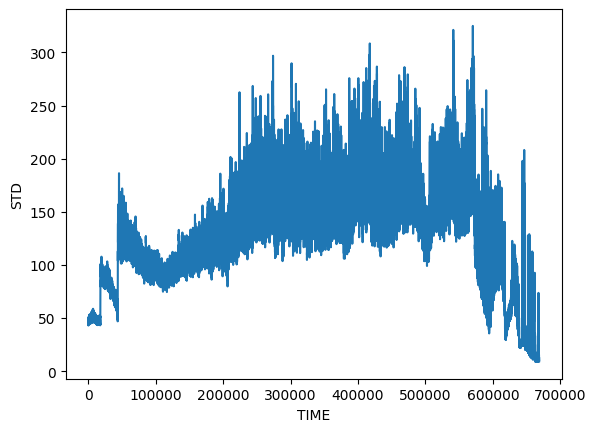

In [3]:
# Seleciona a coluna 'std' do DataFrame
df = df['std']

# Cria uma nova figura do Matplotlib
plt.figure()

# Desenha um gráfico da série Pandas
plt.plot(df)

# Adiciona uma label no eixo x do gráfico com o texto "TIME"
plt.xlabel(f'TIME')

# Adiciona uma label no eixo y do gráfico com o texto "STD"
plt.ylabel('STD')

# Exibe o gráfico na tela
plt.show()

Observe que não é eficiente analisar todos os dados de uma só vez. Portanto, vamos dividir esses dados em intervalos de tempo menores. A câmera SCB-2000N grava a uma taxa média de 25 quadros por segundo, então, ao considerarmos 3000 quadros, estaremos analisando intervalos de tempo de aproximadamente 2 minutos.

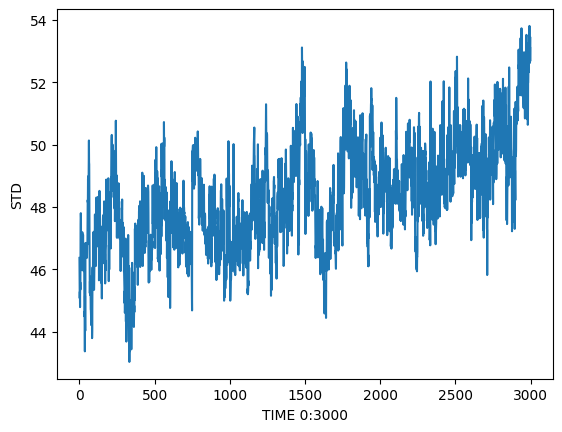

In [4]:
# Cria uma nova figura do Matplotlib
plt.figure()

# Desenha um gráfico da série Pandas, considerando os 3000 primeiros quadros
plt.plot(df[0:3000])

# Adiciona uma label no eixo x do gráfico com o texto "TIME"
plt.xlabel(f'TIME 0:3000')

# Adiciona uma label no eixo y do gráfico com o texto "STD"
plt.ylabel('STD')

# Exibe o gráfico na tela
plt.show()

Observe que, ao observarmos este intervalo de tempo menor, os dados são aproximados, pois em condições normais, durante 2 minutos, não há uma variação significativa de brilho no céu noturno. Dessa forma, podemos definir arbitrariamente um valor de corte para os valores que consideraremos normais. Eu chamo esse valor de `tiny` e ele determina a linha de corte que aplicaremos para desconsiderar ou considerar um intervalo de 2 minutos de vídeo como potencialmente contendo ou não uma passagem de objetos.

Para obtermos o valor de `tiny`, usaremos a seguinte estratégia: definiremos um valor `alpha`, que será multiplicado pelo desvio padrão e, em seguida, somado à média dos dados. Em outras palavras, estaremos obtendo o limite superior de toda a série de dados.

In [5]:
# Código para calcular o valor 'tiny'

# Define o valor de alpha
alpha = 1.0

# Calcula o valor 'tiny' como a média dos dados mais o alpha vezes o desvio padrão
tiny = np.mean(df) + alpha * np.std(df)

tiny

175.93808862541175

Observe que, pelos valores do desvio padrão apresentados no gráfico acima e pela linha de corte definida pelo valor 'tiny', seguindo a metodologia aqui aplicada, é possível que neste intervalo de tempo não haja passagem de objetos. Vamos cortar o trecho de 0 a 3000 quadros para verificar se de fato não houve passagem de objetos neste intervalo.

In [6]:
# Código para cortar um trecho de um vídeo em MP4

# Importa o módulo os
import os

# Define os tempos inicial e final em segundos
t1 = 0 / 25
t2 = 3000 / 25

# Cria a lista de comandos para o ffmpeg
cmd = [
    "/usr/bin/ffmpeg", "-y",  # opções do ffmpeg
    "-ss", "%0.2f" % t1,  # tempo inicial
    "-i", f'./video.mp4',  # arquivo de entrada
    "-t", "%0.2f" % (t2 - t1),  # duração do trecho a ser cortado
    "-map", "0", "-vcodec", "copy", "-acodec", "copy",  # opções de codificação
    f'./subclip_%s_%s.mp4' % (int(t1 * 25), int(t2 * 25))  # arquivo de saída
]

# Exibe o comando final
print(" ".join(cmd))

# Executa o comando
# os.system(" ".join(cmd))

/usr/bin/ffmpeg -y -ss 0.00 -i ./video.mp4 -t 120.00 -map 0 -vcodec copy -acodec copy ./subclip_0_3000.mp4


<video src="subclip_0_3000.mp4" width="640" height="360" controls></video>

Como pode ser observado, de fato, no intervalo apresentado não há passagem de objetos. Portanto, vamos reescrever o algoritmo de forma a que ele analise todos os intervalos do vídeo.

In [7]:
# Importa os módulos os e matplotlib.pyplot
import os
import matplotlib.pyplot as plt

# Importa o módulo numpy
import numpy as np

# Carrega o conjunto de dados para um DataFrame do pandas
df = pd.read_csv('data.csv.gz', compression='gzip', usecols=['std'])

# Dividimos os valores da coluna 'std' por 3 para normalizá-los, pois eles são 
# cumulativos dos três canais de cores: vermelho, verde e azul que foram utilizados para calcular o desvio padrão
df['std'] /= 3

In [8]:
# Define o valor de alpha
alpha = 3.7

# Calcula o valor 'tiny' como a média dos dados mais o alpha vezes o desvio padrão
tiny = np.mean(df, axis=0) + alpha * np.std(df)

tiny

std    298.655253
dtype: float64

In [9]:
# Divide os dados em trechos de 3000 quadros
for chunk in [(i, i + 3000) for i in range(0, df.shape[0], 3000)]:
    # Define os tempos inicial e final em quadros
    t1 = chunk[0]
    t2 = chunk[1]
    
    # Seleciona os dados do trecho atual
    std = df[t1:t2]

    # Verifica se o valor máximo do trecho atual é maior ou igual ao valor 'tiny'
    if std.max(axis=0)[0] >= tiny[0]:
        # Cria um gráfico do trecho atual
        plt.figure()
        
        # Obtém o objeto de eixos do gráfico
        ax = plt.gca()

        # Desenha a série de dados no gráfico
        plt.plot(std)

        # Adiciona uma linha horizontal vermelha na posição y=30
        ax.axhline(y=tiny[0], color='r')

        # Adiciona labels nos eixos do gráfico
        plt.xlabel(f'TIME {t1}:{t2}')
        plt.ylabel('STD')

        plt.savefig(f'./{t1}_{t2}.png')
        # Exibe o gráfico
        # plt.show()
        plt.close()
        
        # Define os tempos inicial e final em segundos
        t1 = t1 / 25
        t2 = t2 / 25
        
        # Cria a lista de comandos para o ffmpeg
        cmd = [
            "/usr/bin/ffmpeg", "-y",  # opções do ffmpeg
            "-ss", "%0.2f" % t1,  # tempo inicial
            "-i", f'./video.mp4',  # arquivo de entrada
            "-t", "%0.2f" % (t2 - t1),  # duração do trecho a ser cortado
            "-map", "0", "-vcodec", "copy", "-acodec", "copy",  # opções de codificação
            f'./subclip_%s_%s.mp4' % (int(t1 * 25), int(t2 * 25))  # arquivo de saída
        ]
        print(" ".join(cmd))
        # Executa o comando
        # os.system(" ".join(cmd))

/usr/bin/ffmpeg -y -ss 16680.00 -i ./video.mp4 -t 120.00 -map 0 -vcodec copy -acodec copy ./subclip_417000_420000.mp4
/usr/bin/ffmpeg -y -ss 21600.00 -i ./video.mp4 -t 120.00 -map 0 -vcodec copy -acodec copy ./subclip_540000_543000.mp4
/usr/bin/ffmpeg -y -ss 22800.00 -i ./video.mp4 -t 120.00 -map 0 -vcodec copy -acodec copy ./subclip_570000_573000.mp4


Observe que o valor de alpha foi manualmente ajustado para 3.7 com o objetivo de filtrar o conjunto de dados e deixá-lo o suficientemente pequeno para ser analisado. Alpha é utilizado como um limite para descartar os valores que são considerados internos em relação à média e ao desvio padrão dos dados. Temos então os três intervalos de dados, candidatos à passagem de objetos. Vejamos o gráfico de cada um desses intervalos.

###### Do quadro 417000 ao 420000 

<img src="417000_420000.png" width="640" height="360"></img>

Observe que, no intervalo entre 417000 e 417500, notamos um aumento crescente do desvio padrão, seguido de uma queda brusca, que faz com que o valor se aproxime novamente da média. Isso sugere que houve uma perturbação nos dados durante esse período de tempo, possivelmente causada pela passagem de um objeto. No entanto, o tempo de crescimento da curva (um pouco mais de 15 segundos) indica que esse objeto provavelmente não é um meteoro ou bólido, que tendem a ter duração muito menor. As características da curva sugerem que o objeto pode ser um satélite, avião ou outro objeto semelhante, mas também é possível que a perturbação seja causada por anomalias nos sensores da câmera (CMOS). Vamos analisar o vídeo recortado deste intervalo de tempo.

<video src="subclip_417000_420000.mp4" width="640" height="360" controls></video>

Ao considerarmos as possibilidades acima, chegamos à conclusão de que a explicação mais provável para a perturbação nos dados é uma anomalia no sensor CMOS da câmera.

###### Do quadro 540000 ao 543000

<img src="540000_543000.png" width="640" height="360"></img>

Observe que a curva deste intervalo tem uma característica diferente da apresentada no gráfico anterior. Ao compararmos com o gráfico anterior, percebemos que a curva deste intervalo apresenta uma característica diferente, com um pico alto de desvio padrão em um curto período de tempo. Pelo que eu tenho visto em minhas análises anteriores, este é um padrão típico de passagens de meteoros ou bólidos. Vamos analisar o trecho do vídeo correspondente a este intervalo para confirmar se ele efetivamente mostra a passagem de um objeto.

<video src="subclip_540000_543000.mp4" width="640" height="360" controls></video>

Como previsto a partir da observação do gráfico, este intervalo de tempo realmente apresenta a passagem de um objeto, provavelmente um meteoro ou bólido.

###### Do quadro 570000 ao 573000

<img src="570000_573000.png" width="640" height="360" controls></img>

Observe que este gráfico tem uma característica diferente das outras duas apresentadas. Ele apresenta um pico expressivo nos valores do desvio padrão e, após este pico, os valores continuam oscilando fortemente por um período de tempo. Embora este padrão possa lembrar a passagem de um meteoro ou bólido (com um pico alto seguido de uma queda), é mais provável que represente a passagem de um avião ou satélite, a menos que se trate de uma chuva de meteoros. Vamos analisar o vídeo recortado deste intervalo de tempo.

<video src="subclip_570000_573000.mp4" width="640" height="360" controls></video>

Observe que há a passagem de um objeto ao longo do vídeo, e que este objeto, de fato, não possui as características de um bólido

# Conclusões

Ao dividir o conjunto de dados em intervalos de tempo mais curtos, fica mais fácil analisar o conjunto geral. Além disso, utilizar um "alpha" como uma linha de corte para determinar se um intervalo de tempo específico possui ou não a passagem de um objeto é útil para restringir o conjunto de dados que estamos analisando.

É possível observar que, em alguns intervalos de tempo, houve a passagem de objetos que apresentaram características diferentes. Em alguns casos, os objetos apresentaram uma curva com um pico alto seguido por uma queda brusca, o que pode indicar a passagem de meteoros ou bólidos. Em outros casos, os objetos apresentaram uma curva com um pico alto seguido por uma série de oscilações, o que pode indicar a passagem de aviões ou satélites. Além disso, foi observado que em alguns intervalos de tempo não houve a passagem de objetos, o que pode ser explicado por um comportamento "normal" dos dados, ou seja, sem a presença de perturbações.

Observa-se também que o algoritmo desenvolvido e a metodologia aplicada podem ser replicados em outros vídeos para auxiliar na detecção de objetos. Em resumo, as análises realizadas permitiram identificar a passagem de diferentes tipos de objetos ao longo do vídeo e o algoritmo desenvolvido pode ser utilizado para realizar essa análise em outros vídeos, o que pode ser útil na detecção de eventos como meteoros ou bólidos. Além disso, é importante levar em consideração que a escolha do valor de "alpha" pode afetar os resultados da análise, e portanto deve ser ajustado de acordo com o conjunto de dados em questão.

Em suma, o algoritmo e a metodologia apresentados neste trabalho foram eficientes na detecção de objetos ao longo do vídeo, permitindo identificar diferentes tipos de objetos e compreender suas características. Essa análise pode ser útil em diversas áreas, como na observação do céu noturno para a detecção de meteoros ou bólidos, ou até mesmo na vigilância de objetos no espaço, como satélites ou aviões.